In [3]:
# General purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow import keras

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Set seed for reproducibility
seed = 42

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlepad = 10)

<Figure size 640x480 with 0 Axes>

In [5]:
# Dataset to train the model :
df_train = pd.read_csv('Corona_NLP_train.csv', encoding = 'ISO-8859-1')
# Dataset to test the performance of the model :
df_test = pd.read_csv('Corona_NLP_test.csv')

df_train = df_train.sample(n = 5000, random_state = 42)
df_test = df_test.sample(n = 1000, random_state = 42)
print(f'Reduced size of training dataset: {df_train.shape[0]}')
print(f'Reduced size of testing dataset: {df_test.shape[0]}')

Reduced size of training dataset: 5000
Reduced size of testing dataset: 1000


In [6]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31089,34888,79840,Lagos,06-04-2020,Without the there would not be any problem wh...,Neutral
35564,39363,84315,NaN,09-04-2020,Rice &amp; wheat prices surge amid fears Covid...,Extremely Negative
144,3943,48895,NaN,16-03-2020,When the government says to start social dista...,Positive
8202,12001,56953,irlande du nord,19-03-2020,What the shops are doing is obeying the law of...,Positive
31720,35519,80471,"Zaria, Nigeria",07-04-2020,Kaduna State Task Force on Covid 19 led by the...,Negative


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 31089 to 27377
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       5000 non-null   int64 
 1   ScreenName     5000 non-null   int64 
 2   Location       3934 non-null   object
 3   TweetAt        5000 non-null   object
 4   OriginalTweet  5000 non-null   object
 5   Sentiment      5000 non-null   object
dtypes: int64(2), object(4)
memory usage: 273.4+ KB


In [8]:
# Convert date column to pandas datetime format
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'])

In [9]:
# Remove duplicates tweets 
df_train.drop_duplicates(subset = 'OriginalTweet', inplace = True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 31089 to 27377
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       5000 non-null   int64         
 1   ScreenName     5000 non-null   int64         
 2   Location       3934 non-null   object        
 3   TweetAt        5000 non-null   datetime64[ns]
 4   OriginalTweet  5000 non-null   object        
 5   Sentiment      5000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 273.4+ KB


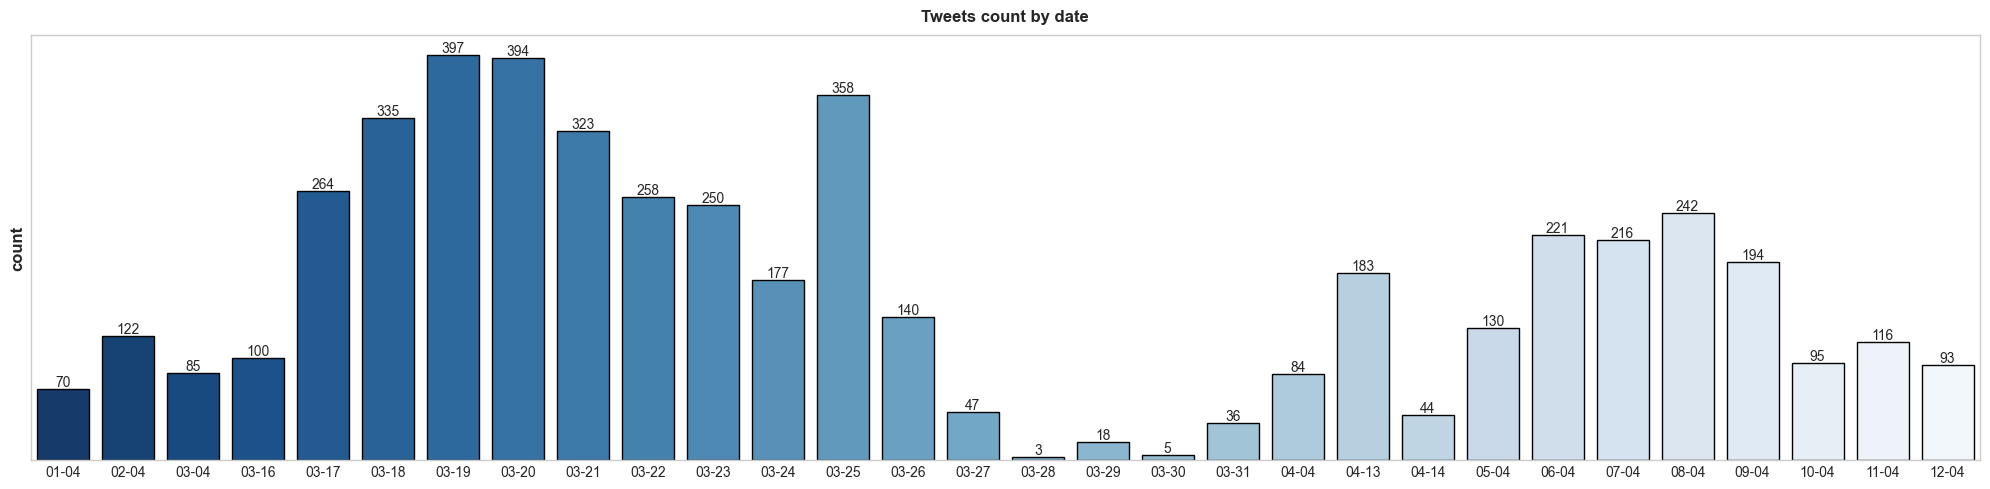

In [10]:
# Display the tweets count by date
tweets_per_day = df_train['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name = 'counts')

plt.figure(figsize = (20,5))
ax = sns.barplot(x = 'index', y = 'counts', data = tweets_per_day, edgecolor = 'black', errorbar = ('ci', False), palette = 'Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [11]:
# Display the tweets count per country and city
tweets_per_country = df_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name = 'counts')

if not tweets_per_country.empty :
    plt.figure(figsize = (15,6))
    ax = sns.barplot(x = 'index', y = 'counts', data = tweets_per_country, edgecolor = 'black', errorbar = ('ci', False), palette='Spectral')
    plt.title('Tweets count by country and city')
    plt.xticks(rotation = 70)
    plt.yticks([])
    ax.bar_label(ax.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    plt.show()
else :
    print("No locations with more than 100 tweets.")

No locations with more than 100 tweets.


In [12]:
# Tweets deep cleaning
df_train = df_train[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [13]:
# Remove emoji
def strip_emoji(text) :
    return emoji.replace_emoji(text, replace = '')

# Remove punctuations, links, mentions and new line characters
def strip_all_entities(text) : 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Remove hashtags
def clean_hashtags(tweet) :
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

# Filter special characters such as "&" and "$" present in some words
def filter_chars(a) :
    sent = []
    for word in a.split(' ') :
        if('$' in word) | ('&' in word) :
            sent.append('')
        else :
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text) :
    return re.sub("\s\s+" , " ", text)

texts_new_train = []
for t in df_train.OriginalTweet :
    texts_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

texts_new_test = []
for t in df_test.OriginalTweet :
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [14]:
# Create a new column for both train and test sets 
df_train['text_clean'] = texts_new_train
df_test['text_clean'] = texts_new_test
df_train['text_clean'].head()

31089    without the there would not be any problem wha...
35564    rice amp wheat prices surge amid fears covid19...
144      when the government says to start social dista...
8202     what the shops are doing is obeying the law of...
31720    kaduna state task force on covid 19 led by the...
Name: text_clean, dtype: object

In [15]:
df_test['text_clean'].head()

1070    at my local grocery store in new hampshire cor...
354     seeing resellers sell masks alcohols and other...
881     where did coronavirus come from and where will...
196     if you still can stock up on dry and canned fo...
3518    popped over at my local supermarket n it s zom...
Name: text_clean, dtype: object

In [16]:
df_train['text_clean'][1:8].values

array(['rice amp wheat prices surge amid fears covid19 lockdown may threaten global food security increased panic buying of food due to coronavirus lockdowns has led to price spikes for worlds two staple grains riceamp wheat importers rushed to stockpile goods',
       'when the government says to start social distancing but you work retail so you cant just not talk to customers in the store lol fml im 100 going to catch covid19',
       'what the shops are doing is obeying the law of demand and supply if we want an ethical distribution of essential consumer items then we must look to socialism thats what we had with rationing in ww2 under an ostensibly conservative pm coronavirus covid19uk borisout',
       'kaduna state task force on covid 19 led by the deputy governor sabuwa balarabe today met with representatives of dealers traders of food and other essential items in sheik gumi market to address the wanton hike on the prices of food items at this critical period',
       'no coron

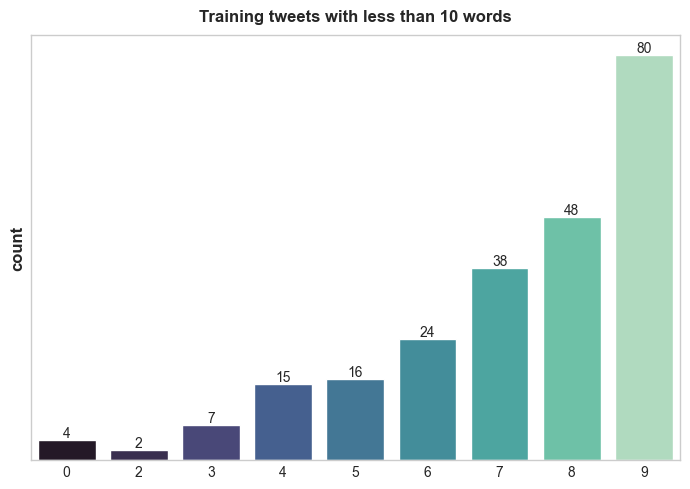

In [17]:
# Create a new column to host the length of the cleaned text
text_len_train = []
for text in df_train.text_clean :
    tweet_len = len(text.split())
    text_len_train.append(tweet_len)
df_train['text_len'] = text_len_train

text_len_test = []
for text in df_test.text_clean :
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)
df_test['text_len'] = text_len_test

plt.figure(figsize = (7,5))
ax = sns.countplot(x = 'text_len', data = df_train[df_train['text_len'] < 10], palette = 'mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

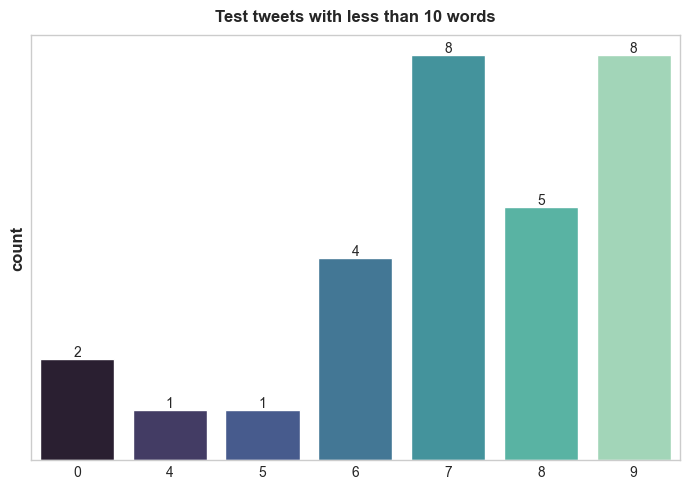

In [18]:
plt.figure(figsize = (7,5))
ax = sns.countplot(x = 'text_len', data = df_test[df_test['text_len'] < 10], palette = 'mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
print(f"df_train shape : {df_train.shape}")
print(f"df_test shape : {df_test.shape}")

df_train shape : (5000, 4)
df_test shape : (1000, 4)


In [20]:
# Remove the empty tweets and also those with less than 5 words
df_train = df_train[df_train['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]
print(f"df_train shape : {df_train.shape}")
print(f"df_test shape : {df_test.shape}")

df_train shape : (4972, 4)
df_test shape : (997, 4)


In [21]:
# Training data deeper cleaning

# Import the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []
for txt in df_train['text_clean'].values :
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens.append(len(tokens))
max_len = np.max(token_lens)

print(f"Max tokenized sentence length : {max_len}")

Max tokenized sentence length : 100


In [22]:
token_lens = []
for i, txt in enumerate(df_train['text_clean'].values) :
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens.append(len(tokens))
    if len(tokens) > 80 :
        print(f"Index : {i}, Text : {txt}")

Index : 3446, Text : zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme


In [23]:
# Drop the text that are not in english
df_train['token_lens'] = token_lens
df_train = df_train.sort_values(by = 'token_lens', ascending = False)
df_train.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
40778,#Covid_19 2days Stay-at-home activities\r\r\nU...,Neutral,covid19 2days stayathome activities up 630am f...,37,75
34288,"$BRZL Scepter Holdings, Inc., Developing Hand ...",Positive,brzl scepter holdings inc developing hand sani...,36,74
9027,La escena se repite alrededor del mundo: desde...,Neutral,la escena se repite alrededor del mundo desde ...,38,72
34867,When you're out of toilet paper and need to bu...,Positive,when youre out of toilet paper and need to buy...,39,72
15953,COVID-19 I Decided To Drop Prices.\r\r\n\r\r\n...,Negative,covid19 i decided to drop prices websiteinclud...,36,72
31157,7 Days in quarantine with @CraigDavid ?\r\r\n-...,Neutral,7 days in quarantine with pandemicbanter covid...,21,71
2505,My Mom walks in to a grocery store and in fron...,Extremely Negative,my mom walks in to a grocery store and in fron...,56,70
2825,"They say that"" The Fijian Competition and Cons...",Extremely Negative,they say that the fijian competition and consu...,46,70


In [24]:
df_train = df_train.iloc[12:]
df_train.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
953,A thought then to those of us with NO INCOME f...,Extremely Negative,a thought then to those of us with no income f...,42,68
4165,Not a single bag of flour on the shelf... 10 s...,Extremely Positive,not a single bag of flour on the shelf 10 seas...,36,68
38817,Artnaturals Alcohol Based Hand Sanitizer Gel (...,Extremely Positive,artnaturals alcohol based hand sanitizer gel 1...,33,68
11204,Cool #daffodils are blooming! Come and get som...,Extremely Positive,cool daffodils are blooming come and get some ...,40,67
13320,"What a nice bloke, all that's been asked is fo...",Extremely Positive,what a nice bloke all thats been asked is for ...,45,67


In [25]:
# Shuffle and reset the index of the dataset
df_train = df_train.sample(frac = 1).reset_index(drop = True)

In [26]:
# Test data deeper cleaning
token_lens_test = []
for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens_test.append(len(tokens))
max_len=np.max(token_lens_test)

print(f"Max tokenized sentence length : {max_len}")

Max tokenized sentence length : 69


In [27]:
token_lens_test = []
for i, txt in enumerate(df_test['text_clean'].values) :
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens_test.append(len(tokens))
    if len(tokens) > 80 :
        print(f"Index : {i}, Text : {txt}")

In [28]:
# Drop the text that are not in english
df_test['token_lens'] = token_lens_test
df_test = df_test.sort_values(by = 'token_lens', ascending = False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,69
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,67
3560,What's the craziest thing you've done in the l...,Negative,whats the craziest thing youve done in the las...,44,67
227,Reporting on COVID-19 Has to stop Many times y...,Positive,reporting on covid19 has to stop many times yo...,53,66
3045,In times like #coronavirus people at #covid19d...,Positive,in times like coronavirus people at covid19deu...,45,65
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,65
2377,Well. My life is about to solely be about work...,Positive,well my life is about to solely be about work ...,60,64
1657,"I was enlightened on the issue of ""panic-buyin...",Negative,i was enlightened on the issue of panicbuying ...,50,64
1960,I went shopping today and the part of town the...,Extremely Negative,i went shopping today and the part of town the...,50,64
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,64


In [29]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,65
2377,Well. My life is about to solely be about work...,Positive,well my life is about to solely be about work ...,60,64
1657,"I was enlightened on the issue of ""panic-buyin...",Negative,i was enlightened on the issue of panicbuying ...,50,64


In [30]:
# Shuffle and reset the index of the dataset
df_test = df_test.sample(frac = 1).reset_index(drop = True)

In [31]:
# Sentiment column analysis
df_train['Sentiment'].value_counts()

Positive              1355
Negative              1219
Neutral                926
Extremely Positive     806
Extremely Negative     654
Name: Sentiment, dtype: int64

In [32]:
# Initialize the sentiment type with numbers
df_train['Sentiment'] = df_train['Sentiment'].map({'Extremely Negative' : -1, 'Negative' : -1, 'Neutral' : 0, 'Positive' : 1, 'Extremely Positive' : 1})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative' : -1, 'Negative' : -1, 'Neutral' : 0, 'Positive' : 1, 'Extremely Positive' : 1})
df_train['Sentiment'].value_counts()

 1    2161
-1    1873
 0     926
Name: Sentiment, dtype: int64

In [33]:
# Class Balancing by RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['Sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment'])
train_os['Sentiment'].value_counts()

-1    2161
 1    2161
 0    2161
Name: Sentiment, dtype: int64

In [34]:
# Train - Validation - Test split
x = train_os['text_clean'].values
y = train_os['Sentiment'].values

# Extract the validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1, stratify = y, random_state = seed)
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [35]:
# One hot encoding
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"Training data : {X_train.shape[0]}\nValidation data : {X_valid.shape[0]}\nTesting data : {X_test.shape[0]}" )

Training data : 5834
Validation data : 649
Testing data : 992


In [36]:
# Naive Bayes classifier

# Tokenize the tweets using CountVectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf = True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [37]:
nb_pred = nb_clf.predict(X_test_tf)
print('\tClassification Report for Naive Bayes :\n\n', classification_report(y_test_le, nb_pred, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes :

               precision    recall  f1-score   support

    Negative       0.67      0.70      0.69       430
     Neutral       0.55      0.38      0.45       156
    Positive       0.65      0.68      0.67       406

    accuracy                           0.65       992
   macro avg       0.62      0.59      0.60       992
weighted avg       0.64      0.65      0.64       992



In [38]:
# BERT Sentiment Analysis

# Custom tokenizer function and call the encode_plus method of the BERT tokenizer
MAX_LEN = 128
def tokenize(data, max_len = MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)) :
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding = 'max_length',
            return_attention_mask = True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Apply the tokenizer function to the train, validation and test datasets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# Import BERT model from pretrained library
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
# BERT modeling
def create_model(bert_model, max_len = MAX_LEN) :
    opt = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5, decay = 1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    
    attention_masks = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    
    embeddings = bert_model([input_ids, attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation = "softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    
    model.compile(opt, loss = loss, metrics = accuracy)
    
    return model

model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [40]:
# Fine tuning the BERT transformer
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data = ([val_input_ids, val_attention_masks], y_valid), epochs = 4, batch_size = 16)

Epoch 1/4
365/365 [==============================] - 1422s 4s/step - loss: 0.8633 - categorical_accuracy: 0.5991 - val_loss: 0.7276 - val_categorical_accuracy: 0.7165
Epoch 2/4
365/365 [==============================] - 1391s 4s/step - loss: 0.5191 - categorical_accuracy: 0.8043 - val_loss: 0.5097 - val_categorical_accuracy: 0.8182
Epoch 3/4
365/365 [==============================] - 1392s 4s/step - loss: 0.2970 - categorical_accuracy: 0.8996 - val_loss: 0.4877 - val_categorical_accuracy: 0.8367
Epoch 4/4
365/365 [==============================] - 1388s 4s/step - loss: 0.1694 - categorical_accuracy: 0.9465 - val_loss: 0.5020 - val_categorical_accuracy: 0.8521


31/31 [==============================] - 71s 2s/step


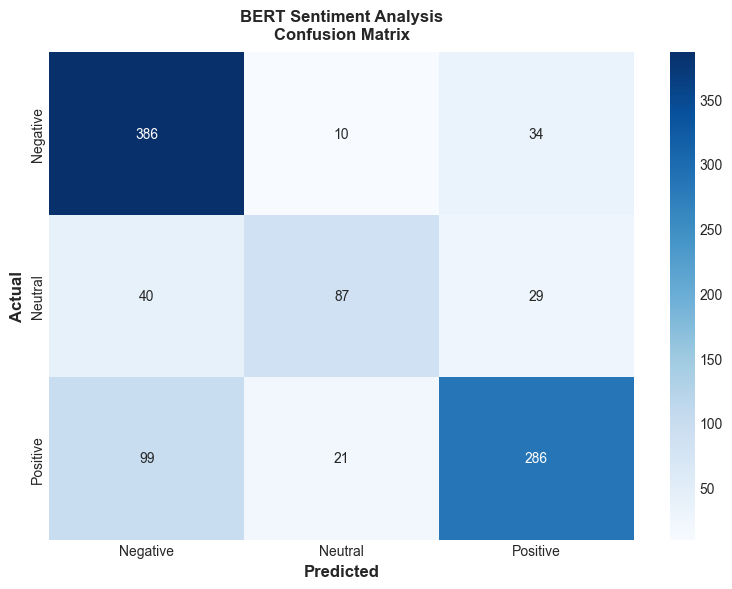

In [41]:
# BERT results 
result_bert = model.predict([test_input_ids, test_attention_masks])

y_pred_bert = np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'd', xticklabels = ['Negative', 'Neutral', 'Positive'], 
            yticklabels = ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Sentiment Analysis\nConfusion Matrix')
plt.show()

In [42]:
print('\tClassification Report for BERT:\n\n', classification_report(y_test, y_pred_bert, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.74      0.90      0.81       430
     Neutral       0.74      0.56      0.64       156
    Positive       0.82      0.70      0.76       406

   micro avg       0.77      0.77      0.77       992
   macro avg       0.76      0.72      0.73       992
weighted avg       0.77      0.77      0.76       992
 samples avg       0.77      0.77      0.77       992



In [43]:
# RoBERTa Sentiment Analysis

tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

# Check the length of the longest tokenized sentence by roberta tokenizer
token_lens = []
for txt in X_train :
    tokens = tokenizer_roberta.encode(txt, max_length = 512, truncation = True)
    token_lens.append(len(tokens))
max_length = np.max(token_lens)
max_length

73

In [44]:
MAX_LEN = 128

# Define the tokenization function
def tokenize_roberta(data,max_len = MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)) :
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens = True,
            max_length = max_len,
            padding = 'max_length',
            return_attention_mask = True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [45]:
# RoBERTa modeling
def create_model(bert_model, max_len = MAX_LEN) :
    
    opt = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5, decay = 1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,), dtype = 'int32')
    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation = tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(opt, loss = loss, metrics = accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [46]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [47]:
# Fine tuning the RoBERTa transformer
history_roberta = model.fit([train_input_ids, train_attention_masks], y_train, validation_data = ([val_input_ids, val_attention_masks], y_valid), epochs = 4, batch_size = 16)

Epoch 1/4
365/365 [==============================] - 1457s 4s/step - loss: 0.8885 - categorical_accuracy: 0.5821 - val_loss: 0.6787 - val_categorical_accuracy: 0.7149
Epoch 2/4
365/365 [==============================] - 1446s 4s/step - loss: 0.5671 - categorical_accuracy: 0.7787 - val_loss: 0.5542 - val_categorical_accuracy: 0.7997
Epoch 3/4
365/365 [==============================] - 1644s 5s/step - loss: 0.3802 - categorical_accuracy: 0.8552 - val_loss: 0.5078 - val_categorical_accuracy: 0.8259
Epoch 4/4
365/365 [==============================] - 1413s 4s/step - loss: 0.2448 - categorical_accuracy: 0.9119 - val_loss: 0.4702 - val_categorical_accuracy: 0.8182


31/31 [==============================] - 71s 2s/step


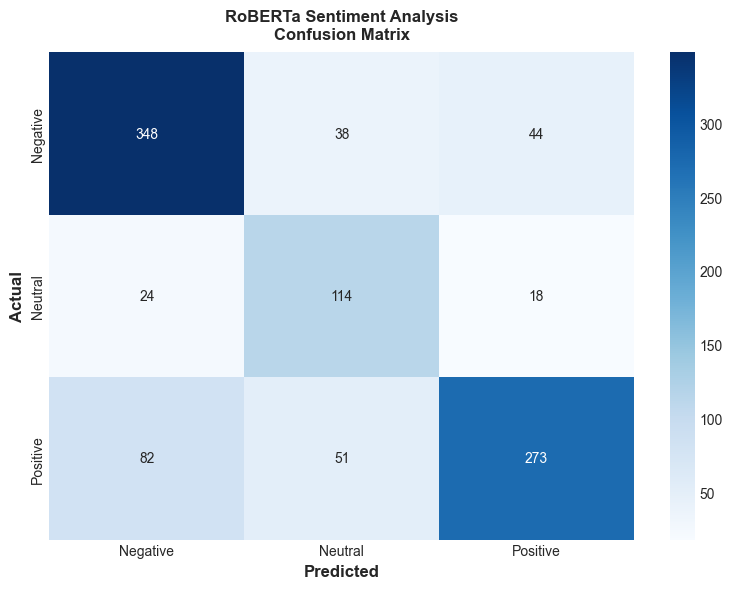

In [48]:
# RoBERTa results
result_roberta = model.predict([test_input_ids, test_attention_masks])

y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

cm2 = confusion_matrix(y_test.argmax(1), y_pred_roberta.argmax(1))
plt.figure(figsize = (8, 6))
sns.heatmap(cm2, annot = True, cmap = 'Blues', fmt = 'd', xticklabels = ['Negative', 'Neutral', 'Positive'], 
            yticklabels = ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RoBERTa Sentiment Analysis\nConfusion Matrix')
plt.show()

In [49]:
print('\tClassification Report for RoBERTa:\n\n', classification_report(y_test, y_pred_roberta, target_names = ['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.77      0.81      0.79       430
     Neutral       0.56      0.73      0.64       156
    Positive       0.81      0.67      0.74       406

   micro avg       0.74      0.74      0.74       992
   macro avg       0.71      0.74      0.72       992
weighted avg       0.75      0.74      0.74       992
 samples avg       0.74      0.74      0.74       992

